In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
PATH = os.path.join("../worldcup", "7566.json")
LABELS = ['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'off_camera', 'team', 'player', 'position', 'location', 'duration', 'under_pressure', 'related_events', 'pass']
TO_DROP = ["id", 'index', 'period', 'timestamp', 'second', 'off_camera']

with open(PATH, encoding="utf-8") as json_file:
    data = json.load(json_file)
    
compositions = data[:2]
events = data[2:]

compositions[0]["team"]["name"]

'Mexico'

In [25]:
def refine(dic) -> list:
    res = []
    for label in LABELS:
        if label in dic.keys():
            res.append(dic[label])
        else:
            res.append(None)
    return res

def clean_list(events) -> list:
    ##### USE THIS #####
    res = []
    for e in events[2:]:
        res.append(refine(e))
    return res

def clean_df(df):
    columns=["type", "possession_team", "play_pattern", "team", "player", "position"]
    for c in columns:
        df[c] = df[c].apply(lambda x : None if x is None else x["name"] )
        
def opp_pos(liste):
    if liste is not None:
        return [125-liste[0], 90-liste[1]]
    return None

def get_df():
    df = pd.DataFrame(clean_list(events), columns=LABELS)
    clean_df(df)
    df = create_data_pass(df)
    df = df.drop(columns=TO_DROP)
    df.loc[df["team"] == "Mexico", "location"] = df.loc[df["team"]== "Mexico", "location"].apply(opp_pos)
    return df
        
        
def create_data_pass(passes) -> pd.DataFrame: 
    columns = ["recipient", "length", "angle", "height", "end_location", "type", "body_part"]
    for c in columns:
        def func(x):
            if x is None:
                return None
            else:
                if c in x.keys():
                    return x[c]
                else:
                    return None
        passes[f"{c}_pass"] = passes["pass"].apply(lambda x : func(x))
    
    need_refine = ["recipient_pass", "height_pass", "type_pass", "body_part_pass"]
    for c in need_refine:
        passes[c] = passes[c].apply(lambda x : None if x is None else x["name"])
    passes = passes.drop(columns=["pass", "related_events"])
    return passes

def get_avg_pos(df, player):
    interest = df.loc[(df["player"] == player)]
    avgX, avgY, n = 0, 0, 0
    
    for i, row in interest.iterrows():
        if row["location"] is not None:
            location = row["location"]
            avgX += location[0]
            avgY += location[1]
            n += 1
        
    return (avgX/n, avgY/n), n

def get_circuit(df_pass, player) -> list:
    interest = df_pass.loc[(df_pass["player"] == player)]
    circuits = list()
    for i, row in interest.iterrows():
        receipt = row["recipient_pass"]
        if receipt is not None:
            circuits.append([row["player"], receipt])
    return circuits
    

In [26]:
df = get_df()
df.head()

,minute,type,possession,possession_team,play_pattern,team,player,position,location,duration,under_pressure,recipient_pass,length_pass,angle_pass,height_pass,end_location_pass,type_pass,body_part_pass
0,0,Pass,2,Sweden,From Kick Off,Sweden,Emil Forsberg,Left Midfield,"[60.0, 41.0]",1.56,None,Andreas Granqvist,24.596748,-2.677945,Ground Pass,"[38.0, 30.0]",Kick Off,Right Foot
1,0,Ball Receipt*,2,Sweden,From Kick Off,Sweden,Andreas Granqvist,Left Center Back,"[38.0, 30.0]",NaN,None,None,NaN,NaN,None,None,None,None
2,0,Carry,2,Sweden,From Kick Off,Sweden,Andreas Granqvist,Left Center Back,"[38.0, 30.0]",1.36,True,None,NaN,NaN,None,None,None,None
3,0,Pressure,2,Sweden,From Kick Off,Mexico,Javier Hernández Balcázar,Center Forward,"[42.0, 49.0]",1.24,None,None,NaN,NaN,None,None,None,None
4,0,Pass,2,Sweden,From Kick Off,Sweden,Andreas Granqvist,Left Center Back,"[38.0, 34.0]",3.04,True,Ola Toivonen,60.811184,0.785398,High Pass,"[81.0, 77.0]",None,Right Foot


In [6]:
home = {"team": compositions[0]["team"]["name"], "formation": compositions[0]["tactics"]["formation"], "lineup": compositions[0]["tactics"]["lineup"]}

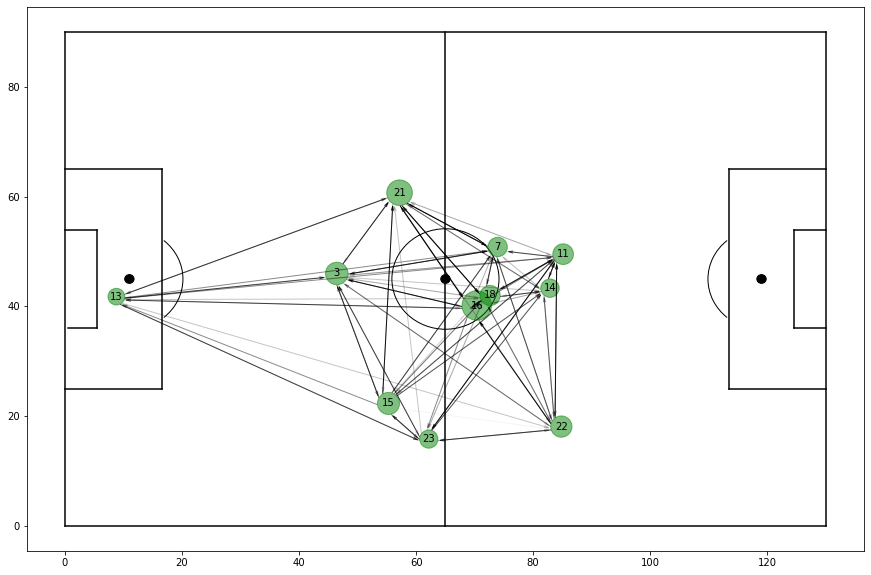

In [7]:
def get_team_avg(df, lineup):
    dic = dict()
    for player in lineup["lineup"]:
        name = player["player"]["name"]
        jersey = player["jersey_number"]
        avg, n = get_avg_pos(df, name)
        dic[name] = { "avg_pos" : avg, "n_touch": n, "jersey": jersey}
        
    return dic


def refine_tc(circuits):
    res = {}
    for link in circuits:
        tupl = tuple(link)
        if tupl not in res.keys():
            res[tupl] = 0
        res[tupl] += 1
    return res


def get_team_circuits(df, lineup) -> dict:
    res = []
    for player in lineup["lineup"]:
        name = player["player"]["name"]
        circuit = get_circuit(df, name)
        res = res + circuit
        
    return refine_tc(res)


FACTOR = 5

def get_sizes(positions):
    summ = 0
    for k, v in positions.items():
        summ += v["n_touch"]
    for k, v in positions.items():
        v["n_touch"] = v["n_touch"] * FACTOR / summ
    
    return positions
        

def plot_avg_map(positions, ax) -> dict:
    # Adds player object to dictionnary
    positions = get_sizes(positions)
    for name, v in positions.items():
        avg_pos = v["avg_pos"]
        nb_t = v["n_touch"]
        jersey = v["jersey"]
        bbox = dict(facecolor='green', edgecolor='green', boxstyle=f'circle,pad={nb_t}', alpha=0.5)
        obj = ax.text(avg_pos[0], avg_pos[1], jersey, color="black", bbox=bbox)
        
        positions[name]["obj"] = obj
    
    return positions
    
IDK = 100
        
def plot_circuits(df, team, positions, ax):
    circuits = get_team_circuits(df, team)
    total = sum([x for x in circuits.values()])
    for tupl, number in circuits.items():
        src, dst = tupl[0], tupl[1]
        if src in positions.keys() and dst in positions.keys():
            pos_src, pos_dst = positions[src]["avg_pos"], positions[dst]["avg_pos"]
            obj_src, obj_dst = positions[src]["obj"], positions[dst]["obj"]
            width = number / total
            ax.annotate("", xy=pos_dst, xytext=pos_src, arrowprops=dict(arrowstyle='->, head_width=0.1', facecolor='red',  \
                                                                         alpha=width*IDK, patchB=obj_dst,shrinkB=0, patchA=obj_src, shrinkA=0), \
                         textcoords='data')
    
        
fig, ax = create_pitch()
positions = get_team_avg(df, home)
positions = plot_avg_map(positions, ax)
plot_circuits(df, home, positions, ax)

In [200]:
df.head()

,minute,type,possession,possession_team,play_pattern,team,player,position,location,duration,under_pressure,recipient_pass,length_pass,angle_pass,height_pass,end_location_pass,type_pass,body_part_pass
0,0,Pass,2,Sweden,From Kick Off,Sweden,Emil Forsberg,Left Midfield,"[60.0, 41.0]",1.56,None,Andreas Granqvist,24.596748,-2.677945,Ground Pass,"[38.0, 30.0]",Kick Off,Right Foot
1,0,Ball Receipt*,2,Sweden,From Kick Off,Sweden,Andreas Granqvist,Left Center Back,"[38.0, 30.0]",NaN,None,None,NaN,NaN,None,None,None,None
2,0,Carry,2,Sweden,From Kick Off,Sweden,Andreas Granqvist,Left Center Back,"[38.0, 30.0]",1.36,True,None,NaN,NaN,None,None,None,None
3,0,Pressure,2,Sweden,From Kick Off,Mexico,Javier Hernández Balcázar,Center Forward,"[83.0, 41.0]",1.24,None,None,NaN,NaN,None,None,None,None
4,0,Pass,2,Sweden,From Kick Off,Sweden,Andreas Granqvist,Left Center Back,"[38.0, 34.0]",3.04,True,Ola Toivonen,60.811184,0.785398,High Pass,"[81.0, 77.0]",None,Right Foot


In [201]:
passes = get_pass_df(df)

passes.head()

,minute,type,possession,possession_team,play_pattern,team,player,position,location,duration,under_pressure,recipient_pass,length_pass,angle_pass,height_pass,end_location_pass,type_pass,body_part_pass
0,0,Pass,2,Sweden,From Kick Off,Sweden,Emil Forsberg,Left Midfield,"[60.0, 41.0]",1.560,None,Andreas Granqvist,24.596748,-2.677945,Ground Pass,"[38.0, 30.0]",Kick Off,Right Foot
4,0,Pass,2,Sweden,From Kick Off,Sweden,Andreas Granqvist,Left Center Back,"[38.0, 34.0]",3.040,True,Ola Toivonen,60.811184,0.785398,High Pass,"[81.0, 77.0]",None,Right Foot
6,0,Pass,2,Sweden,From Kick Off,Sweden,Ola Toivonen,Left Center Forward,"[81.0, 77.0]",0.920,None,None,13.601471,-0.628796,High Pass,"[92.0, 69.0]",None,Head
9,1,Pass,3,Sweden,From Free Kick,Sweden,Sebastian Larsson,Right Center Midfield,"[81.0, 70.0]",2.240,None,Marcus Berg,55.470715,-0.977794,High Pass,"[112.0, 24.0]",Free Kick,Right Foot
11,1,Pass,3,Sweden,From Free Kick,Sweden,Marcus Berg,Right Center Forward,"[112.0, 24.0]",1.333,None,Andreas Granqvist,18.439089,1.352127,Low Pass,"[116.0, 42.0]",None,Head


In [202]:
def get_pass_df(df):
    return df.loc[(df["type"] == "Pass")].copy()

def get_team_df(df, team):
    name = team["team"]
    return df.loc[df["team"] == name].copy()

df.type.unique()

array(['Pass', 'Ball Receipt*', 'Carry', 'Pressure', 'Foul Committed',
       'Foul Won', 'Ball Recovery', 'Camera On', 'Block', 'Duel', 'Shot',
       'Goal Keeper', 'Dribbled Past', 'Dribble', 'Clearance',
       'Interception', 'Miscontrol', 'Camera off', 'Dispossessed',
       '50/50', 'Half End', 'Half Start', 'Injury Stoppage',
       'Substitution', 'Referee Ball-Drop', 'Tactical Shift',
       'Own Goal For', 'Own Goal Against', 'Offside'], dtype=object)

In [203]:
# df.loc[df["type"] == "Goal Keeper"]

In [204]:
d = df.loc[(df["possession"] == 21) & (df["team"] == "Senegal")]
d.loc[d["type"] == "Shot"]

,minute,type,possession,possession_team,play_pattern,team,player,position,location,duration,under_pressure,recipient_pass,length_pass,angle_pass,height_pass,end_location_pass,type_pass,body_part_pass


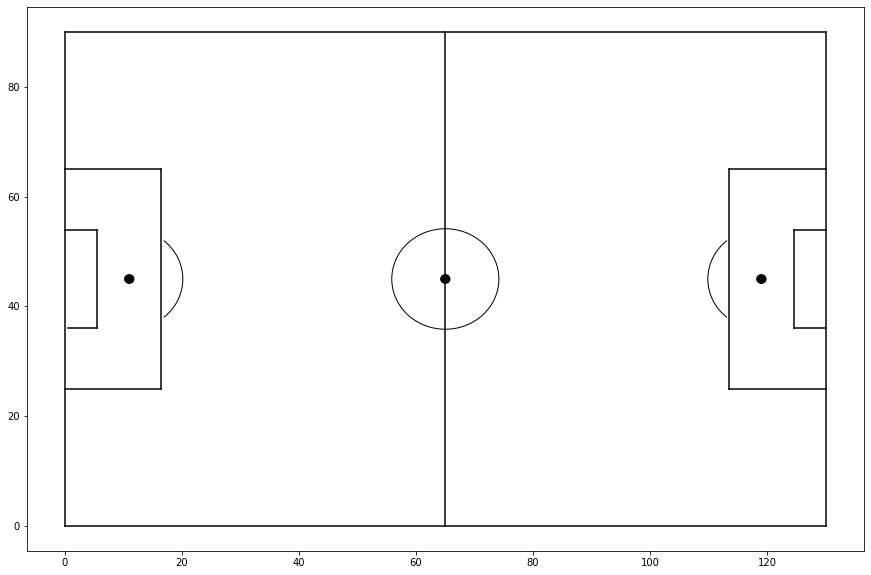

In [205]:
create_pitch()
for index, (i, row) in enumerate(d.iterrows()):
    if row["type"] == "Pass":
        start, end = row["location"], row["end_location_pass"]
        plt.plot((start[0], end[0]), (start[1], end[1]), color="blue")
        plt.text(start[0], start[1], f"{index}")
        plt.plot(start[0], start[1], "o", color="green")
    elif row["type"] == "Carry":
        start = row["location"]
        end = d.iloc[index+1]["location"]
        plt.text(start[0], start[1], f"{index}")
        plt.plot((start[0], end[0]), (start[1], end[1]), color="orange")
        plt.plot(start[0], start[1], "o", color="red")
    elif row["type"] == "Shot":
        point = row["location"]
        end = df.iloc[i+1]["location"]
        print(end)
        plt.plot((start[0], 125-end[0]), (start[1], end[1]), color="purple")
        #plt.text(start[0], start[1], f"{index}")
    else:
        point = row["location"]
        plt.plot(point[0], point[1], "^", color="black")
        #plt.text(start[0], start[1], f"{index}")
            
a = df.iloc[395]

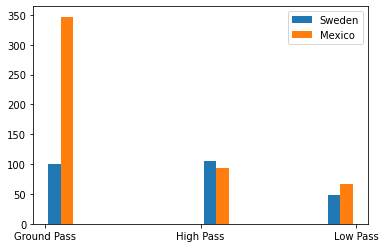

In [206]:
def display_hist(df):
    teams = list(df.team.unique())
    res = {}
    for t in teams:
        temp = df.loc[(df["team"] == t) & ((df["height_pass"].notnull()))].copy()
        #print(temp.height_pass)
        res[t] = list(temp["height_pass"])
        
    
    fig, ax = plt.subplots()    
    ax.hist(res.values(), label=list(res.keys()))
    ax.legend()
    
display_hist(df)

In [9]:
#df.loc[df["player"] == "Francisco Guillermo Ochoa Magaña"]
compositions.sort(key=lambda x: x["team"]["name"])

In [10]:
compositions

[{'id': 'f0636101-45dd-4b25-be42-c3b3e39cdc56',
  'index': 1,
  'period': 1,
  'timestamp': '00:00:00.000',
  'minute': 0,
  'second': 0,
  'type': {'id': 35, 'name': 'Starting XI'},
  'possession': 1,
  'possession_team': {'id': 794, 'name': 'Mexico'},
  'play_pattern': {'id': 1, 'name': 'Regular Play'},
  'team': {'id': 794, 'name': 'Mexico'},
  'duration': 0.0,
  'tactics': {'formation': 4231,
   'lineup': [{'player': {'id': 5577,
      'name': 'Francisco Guillermo Ochoa Magaña'},
     'position': {'id': 1, 'name': 'Goalkeeper'},
     'jersey_number': 13},
    {'player': {'id': 5567, 'name': 'Edson Omar Álvarez Velázquez'},
     'position': {'id': 2, 'name': 'Right Back'},
     'jersey_number': 21},
    {'player': {'id': 5564, 'name': 'Carlos Joel Salcedo Hernández'},
     'position': {'id': 3, 'name': 'Right Center Back'},
     'jersey_number': 3},
    {'player': {'id': 5573, 'name': 'Héctor Alfredo Moreno Herrera'},
     'position': {'id': 5, 'name': 'Left Center Back'},
     'jer